## Relevant resources
- API keys: https://towardsdatascience.com/how-to-hide-your-api-keys-in-python-fb2e1a61b0a0
- python wrapper for binance api: https://github.com/sammchardy/python-binance
- possibly for final version, candlestick charts: https://www.pricederivatives.com/en/how-to-display-candle-stick-bars-from-binance-futures-in-jupyter-notebook/

In [1]:
# import packages
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle



# get api keys for binance 
import os
API_PUBLIC = os.environ.get("PUBLIC_KEY")
API_SECRET = os.environ.get("SECRET_KEY")

Aim is to fetch the top 5 cryptocurrencies by marketcap i.e. BTC, ETH, XRP, BCH and BNB denominated in US dollars (USDt).

In [4]:
crypto_pairs = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'BNBUSDT']

In [5]:
# iteratively loop through cryptocurrencies in crypto_pairs and download them into dataframes
# set granularity of time series
timeperiod = '1m' # hourly
client = Client(API_PUBLIC, API_SECRET)
timestamp = []
for pair in crypto_pairs:
    # determine first available price point
    timestamp.append(client._get_earliest_valid_timestamp(pair, timeperiod)) 
# assign first available price point to be be the latest in time
timestamp = max(timestamp)

In [6]:
startdate = timestamp #"1 Jan, 2019"
df = {} # create a dictionary that will eventually contain currency dataframes
for pair in crypto_pairs:
    klines = client.get_historical_klines(pair, timeperiod, startdate)
    
    # delete unwanted data - just keep date, open, high, low, close
    for line in klines:
        del line[6:]
        
    # cast into dataframe and index with date
    df[pair] = pd.DataFrame(klines, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df[pair]['date'] = pd.to_datetime(df[pair]['date'],unit='ms')
    df[pair].set_index('date', inplace=True)
    
    # previous testing showed that the columns of df are objects. convert to float
    df[pair] = df[pair].astype(float)

Save data in pickle format

In [8]:
with open('cryptopairs24102020_minute.pkl', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

Load data from pickle file

In [2]:
with open('cryptopairs20102020.pkl', 'rb') as handle:
    df = pickle.load(handle)

24/10/2020 Dependency problems means that we have to use an older version of pandas. Causes problems for pickle imports. So instead, convert to csv. The data loading part will be put in the notebook containing the actual trading strategy:

In [3]:
for key in df:
    df[key].to_csv('hourly/'+key + '.csv')
    print(key)

ETHUSDT
BTCUSDT
BNBUSDT
XRPUSDT
BCHUSDT


In [4]:
with open('cryptopairs24102020_minute.pkl', 'rb') as handle:
    df = pickle.load(handle)
    
for key in df:
    df[key].to_csv('minutely/'+key + '.csv')
    print(key)

BCHUSDT
BTCUSDT
XRPUSDT
ETHUSDT
BNBUSDT


Test code to import data (and index the date right)

In [ ]:
test=pd.read_csv('ETHUSDT.csv')
test.set_index('date', inplace=True)

Plot cryptocurrencies 

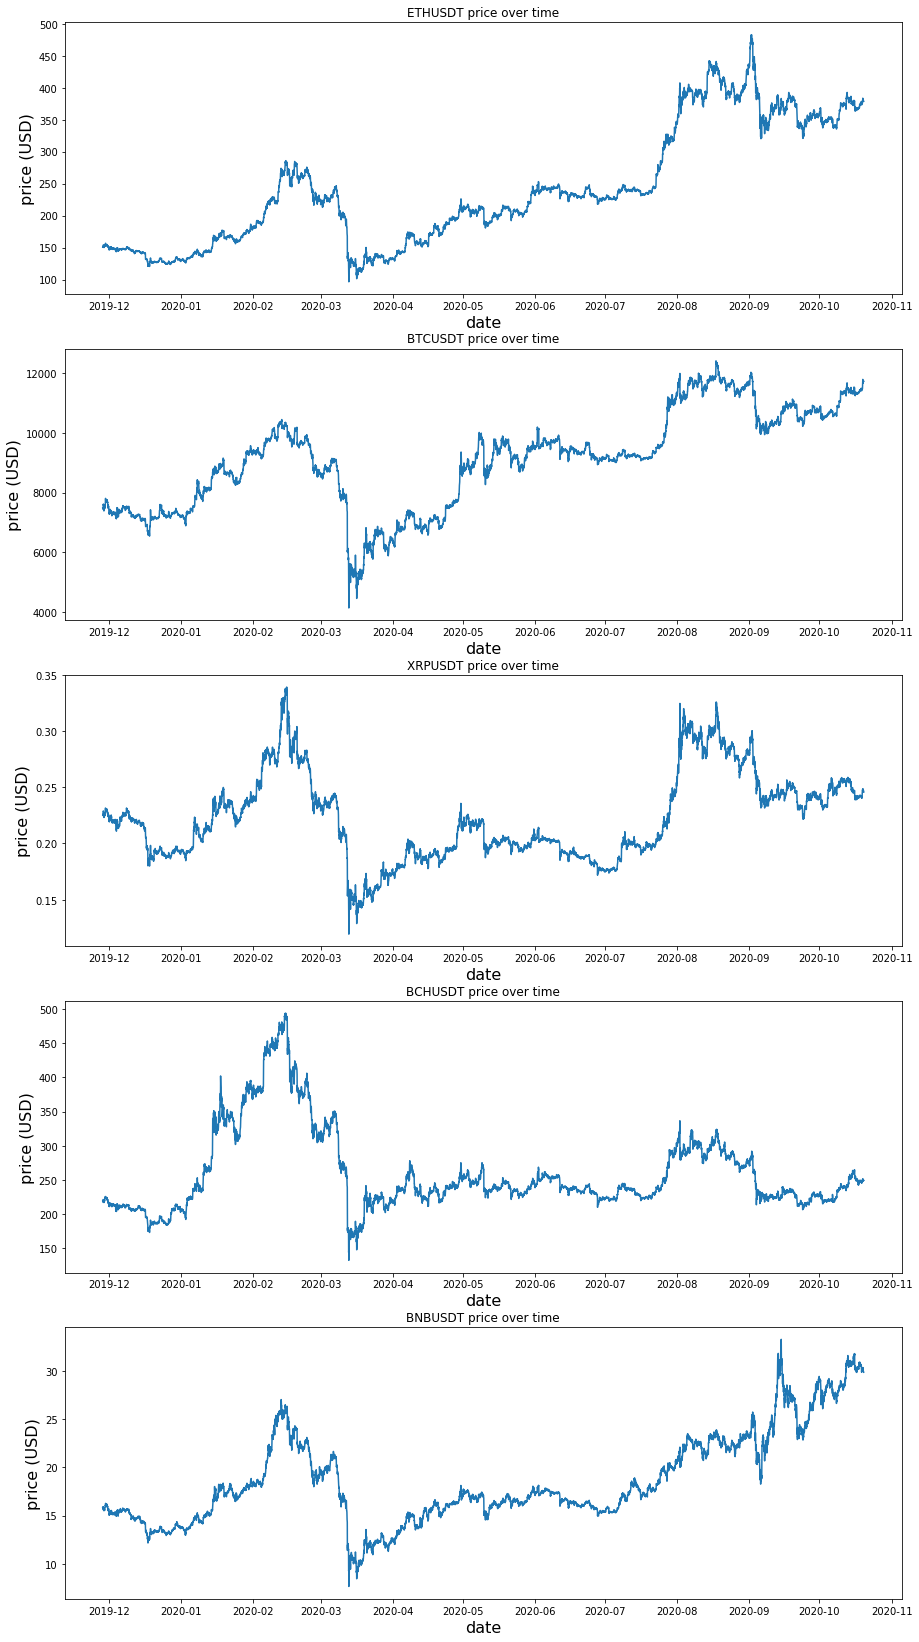

In [8]:
fig, ax = plt.subplots(len(df),figsize=(15, 29))

for i in range(len(df)):
    ax[i].plot(df[list(df.keys())[i]]['close']) # stacked plot of each of the currencies
    ax[i].set_title(list(df.keys())[i] + ' price over time') # set plot titles
    

# set axes labels
for i in range(len(df)):
    ax[i].set_xlabel('date',fontsize=16)
    ax[i].set_ylabel('price (USD)', fontsize=16)

Inspection alone suggests that there is cross correlation between these time series

## Old code for testing

Determine first available price point

In [7]:
client = Client(API_PUBLIC, API_SECRET)
timestamp = client._get_earliest_valid_timestamp('BNBUSDT', '1d')

In [8]:
timestamp

1509926400000

In [9]:
startdate = timestamp #"1 Jan, 2019"
klines = client.get_historical_klines("BNBUSDT", '1d', startdate)

Column 4 corresponds to adjusted close while column 6 corresponds to close time (in milliseconds since the 1 Jan, 2017 or the start date specified above. See https://python-binance.readthedocs.io/en/latest/binance.html#binance.client.Client.get_klines

In [10]:
# delete unwanted data - just keep date, open, high, low, close
for line in klines:
    del line[6:]

In [11]:
df = pd.DataFrame(klines, columns=['date', 'open', 'high', 'low', 'close', 'volume']) # ignoring other columns
# df['date'] = pd.to_datetime(df['date'],unit='D', origin=pd.Timestamp('1960-01-01'))
df['date'] = pd.to_datetime(df['date'],unit='ms')
df.set_index('date', inplace=True)
print(df.head())

                  open        high         low       close
date                                                      
2017-11-06  1.50000000  1.79900000  0.50000000  1.57100000
2017-11-07  1.57100000  1.80000000  1.53890000  1.80000000
2017-11-08  1.79010000  1.99000000  1.74790000  1.98890000
2017-11-09  1.97810000  2.19970000  1.90000000  1.99000000
2017-11-10  1.99000000  2.02000000  1.60190000  1.71330000


In [ ]:
print(df.dtypes)

In [35]:
df = df.astype(float)

open     float64
high     float64
low      float64
close    float64
dtype: object

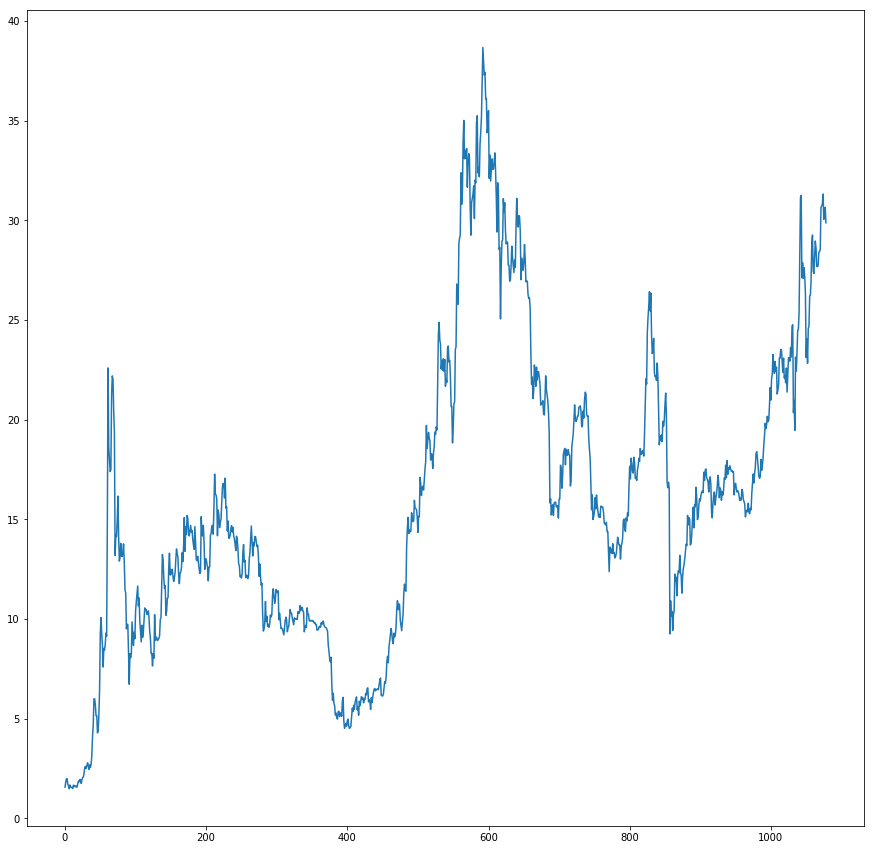

In [37]:
fig, ax = plt.subplots(1,figsize=(15,15))
ax.plot(df['close'].values)

In [ ]:
df = pd.DataFrame(klines)

In [78]:
# save df to pickle so it doesn't have to be downloaded again
df.to_pickle('test_dataset19102020.pkl')

In [79]:
# load dataset from pickle
df = pd.read_pickle('test_dataset19102020.pkl')